# *FARADAY ROTATION* | Lab-Session #7
## Apr-1-2021 13:45

Here we perform the analysis of all the measurements

In [60]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as consts
from tqdm import tqdm
import os
from csvlib import *
from scipy.optimize import curve_fit

# Display mpl in notebook format
%matplotlib inline

# Data Analysis

Here are the functions we used to analyse our data

In [168]:
# First we pick a data set using a folder name
directory = 'AC_VERDET_ROD'     # Directory of the data

# Now define some parameters for the experiment
params = {
    'P_max'        : 1e-3,           # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 1,              # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 1,              # Lock in Gain
    'K_lock_in'    : 1/2,            # Lock in Constant
    'G_lp_amp'     : 1,              # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 1e-2,           # Material length in the solenoid in m
    'Sigma_L'      : 1e-3,           # Uncertainty in Length
}

# print the setup file for this directory
def print_setup(directory=directory):
    file = open(directory+'/Setup.txt')
    lines = file.readlines()
    file.close
    
    for line in lines:
        print(line,end='')

# Returns a data frame for the measurements of that particular angle
def get_angle(angle,directory=directory):
    angle = int(angle)
    data = pd.read_csv(directory+'/Angle-%d.csv'%angle)

    return data.to_numpy().T

# Get the raw data for voltage and amplitude
def get_voltage_vs_amplitude(directory=directory):
    data = pd.read_csv(directory+'/Voltage-Amplitude.csv'%angle)
    return data.to_numpy().T

# Returns average and standard deviation
def get_stats(data):
    return np.mean(data), np.std(data)

# Returns a calculated data set with mean and stds for a set of angles
def voltage_vs_angle(angles=np.linspace(0,360,360,dtype=int),directory=directory,channel=5):
    V = []
    V_std = []
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        mean,std = get_stats(data[channel])

        V.append(mean)
        V_std.append(std)

    return np.array(V),np.array(V_std),angles

# get the raw data for the current among a list of angles
def get_current_ac(angles=np.linspace(0,360,360,dtype=int),directory=directory,channel=1):
    time  = np.array(get_angle(0)[0])
    I     = np.zeros(time.shape)
    I_std = np.zeros(time.shape)
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        I += data[channel]
    
    I = np.array(I)/len(angles)
    I_avg = np.mean(I)
    
    for angle in tqdm(angles):
        data = get_angle(angle,directory=directory)
        I_std += (np.array(data[channel]) - I_avg)**2
    
    I_std /= len(angles)
    
    return I, I_std**0.5, time



# obtain the phase difference and verdet constant due to rotation from the signal amplitude plot
def calc_verdet_ac(voltage,voltage_std,current,current_std,average=0.95,params=params):
    # First calculate the phase shift from the amplitude of the signal
    V_max = np.mean([abs(i) for i in voltage if abs(i)/max(voltage) >= average])
    
    Gain  = params['G_preamp']*params['G_filter']*params['G_lp_amp']*params['G_lock_in']
    K     = params['K_sensor']
    R     = params['R_sensor']
    K_loc = params['K_lock_in']
    P     = params['P_max']
    
    # This is the phase shift
    f = np.sqrt( 2 * V_max / (Gain * K * K_loc * R * P) )
    Delta_phi = np.arcsin(f)*180/np.pi - 3.5
    
    # To get the phase uncertainty 
    sigma_V = (np.sum([voltage_std[i]**2 for i in range(len(voltage)) if abs(voltage[i])/max(voltage) >= average]))**0.5
    sigma_phi = abs(sigma_V/( (1-f**2)**0.5 * f))
    
    
    
    # Now to get the Verdet constant
    I_max = np.mean([abs(i) for i in current if abs(i)/max(current) >= average])
    
    B = params['K_solenoid'] * I_max
    l = params['Length']
    
    Verdet = Delta_phi / (B * l)
    
    # To get the verdet uncertainty
    sigma_I = (np.sum([current_std[i]**2 for i in range(len(current)) if abs(current[i])/max(current) >= average]))**0.5
    sigma_I = abs(sigma_I * Verdet/I_max)
    sigma_L = abs(params['Sigma_L']*Verdet/l)
    
    sigma_Verdet = (sigma_I**2 + sigma_L**2 + (sigma_phi/(B*l))**2 )**0.5
    
    # Return the two values
    return Verdet, sigma_Verdet, Delta_phi, sigma_phi
    

# obtain the phase difference and verdet constant due to rotation from the signal amplitude plot
def calc_verdet_dc(angle,voltage,voltage_std,current,current_std,average=0.95,params=params):
    # Calculate delta phi
    angles    = [angle[i]%90 for i in range(len(voltage)) if abs(voltage[i])/max(voltage) >= average]
    Delta_phi = np.mean(angles) - 5
    sigma_phi = np.std(angles)
    print(angles)
    
    # Now to get the Verdet constant
    I_max = current
    
    B = params['K_solenoid'] * I_max
    l = params['Length']
    
    Verdet = Delta_phi / (B * l)
    
    # To get the verdet uncertainty
    sigma_I = current_std
    sigma_I = abs(sigma_I * Verdet/I_max)
    sigma_L = abs(params['Sigma_L']*Verdet/l)
    
    sigma_Verdet = (sigma_I**2 + sigma_L**2 + (sigma_phi/(B*l))**2 )**0.5
    
    # Return the two values
    return Verdet, sigma_Verdet, Delta_phi, sigma_phi
    
    
    

# Plot a voltage VS amplitude graph
def plot_VA(agnles=np.linspace(0,360,360,dtype=int),directory=directory,channel=5):
    V,V_std,angles = voltage_vs_angle(directory=directory,channel=channel)

    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111)
    ax.errorbar(angles,V,yerr=V_std,color='deepskyblue')

    return fig,ax

# Plot the lock in at a particular angle
def plot_lock_in(angle,directory=directory):
    data    = get_angle(angle,directory=directory)
    time    = data[2]
    lock_in = data[3]

    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    ax.plot(time,lock_in,color='mediumseagreen')

    return fig,ax

# DC Verdet Analysis

Here we present the calculatiosn of the verdet constant for the DC experiments for the rod, providing the appropriate plots. 

 12%|█▏        | 44/360 [00:00<00:00, 438.99it/s]

VERDET Rod DC

LENGTH:     10.175 ± 0.005 cm
DC Current: 805.5 + 1.70 mA

100%|██████████| 360/360 [00:00<00:00, 434.38it/s]


[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 12, 13, 14, 15]
V:	 77.43632093770472 77.43650274419234
φ:	 4.0 4.0


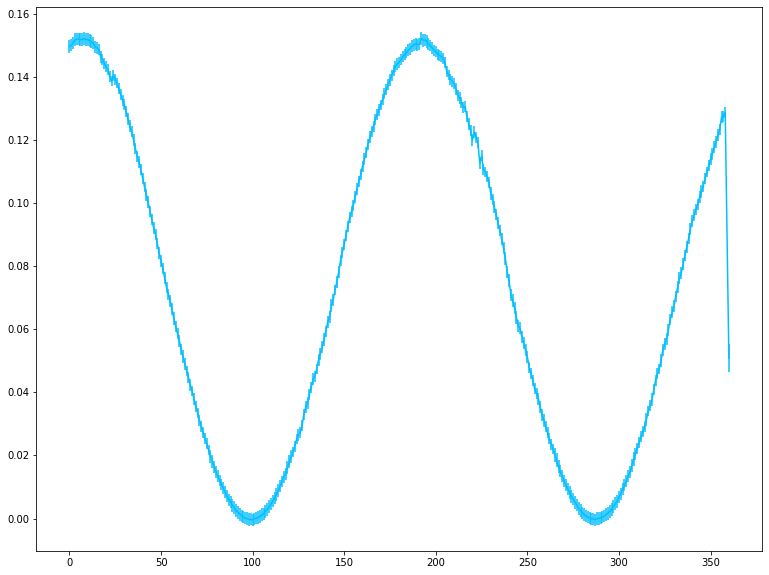

In [160]:
# Set the directory with the measurements
directory = 'DC_VERDET_ROD'

# Set the parameters of the experiment
params = {
    'P_max'        : 1e-3,           # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 1,              # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 1,              # Lock in Gain
    'K_lock_in'    : 1/2,            # Lock in Constant
    'G_lp_amp'     : 1,              # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 10.175e-2,      # Material length in the solenoid in m
    'Sigma_L'      : 0.005e-2,       # Uncertainty in Length in m
}
current       = 805.5e-3             # DC Current in coil in A
current_std   = 1.70e-3              # Uncertainty in current in mA
angle         = np.linspace(0,360,360,dtype=int)
channel       = 3

# Get the relevant data
voltage,voltage_std,angles = voltage_vs_angle(directory=directory,channel=channel)

print_setup(directory)          # Print the setup for the particular experiment

# Plot the voltage VS angle curve
fig,ax = plot_VA(directory=directory,channel=3)

# Calculate Verdet constant
V,V_std, Phi,Phi_std = calc_verdet_dc(angle,voltage,voltage_std,current,current_std,average=0.99,params=params)

print("V:\t",V*np.pi/180,V_std*np.pi/180) # 21.0 rad/Tm
print("φ:\t",Phi,Phi_std)

# AC Verdet analyisis
This will perform the analysis for the verdet constant of the ROD done using lock in amplification

100%|██████████| 360/360 [00:00<00:00, 399.11it/s]


V:	 32.11793458290976 319.7112642165882
φ:	 1.388832346308999 3.175545940398869


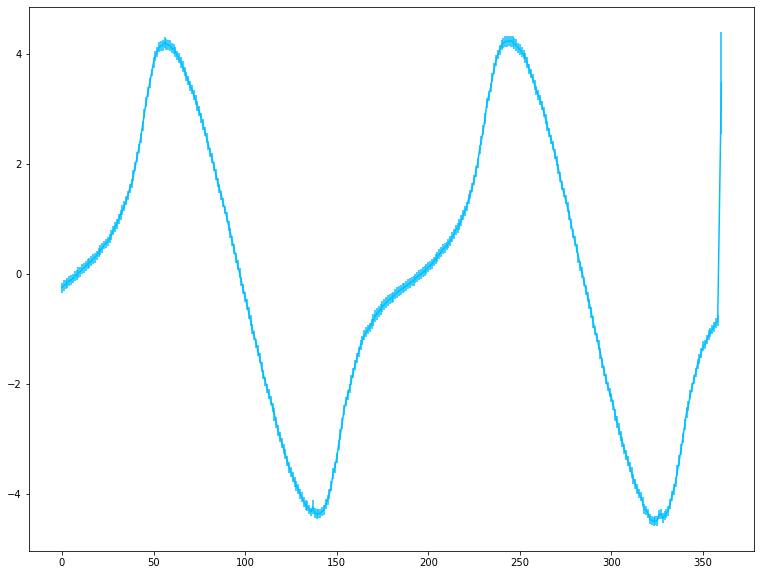

In [169]:
# Set the directory with the measurements
directory = 'AC_VERDET_ROD'

# Set the parameters of the experiment
params = {
    'P_max'        : 1e-3,           # Laser source power in W
    'R_sensor'     : 1e+3,           # Sensor Resistance in Ω
    'K_sensor'     : 0.6,            # Sensor Responsivity in A/W
    'G_preamp'     : 10,             # Preamplifier Gain
    'G_filter'     : 1,              # Low Pass filter Gain
    'G_lock_in'    : 20,             # Lock in Gain
    'K_lock_in'    : 1/2,            # Lock in Constant
    'G_lp_amp'     : 20,             # Lock in, low pass amplifier gain
    'K_solenoid'   : 0.011,          # Solenoid constant in T/A
    'Length'       : 10.175e-2,      # Material length in the solenoid in m
    'Sigma_L'      : 0.005e-2,       # Uncertainty in Length in m
}
angle = np.linspace(0,360,360,dtype=int)

# Get the relevant data
voltage,voltage_std,angles = voltage_vs_angle(directory=directory)
voltage -= np.mean(voltage)
current, current_std, time = get_current_ac(directory=directory)

# print_setup(directory)          # Print the setup for the particular experiment

# Plot the voltage VS angle curve
fig,ax = plot_VA(directory=directory)

# Calculate Verdet constant
V,V_std, Phi,Phi_std = calc_verdet_ac(voltage,voltage_std,current,current_std,average=0.999,params=params)

print("V:\t",V*np.pi/180,V_std*np.pi/180) # 21.0 rad/Tm
print("φ:\t",Phi,Phi_std)

100%|██████████| 360/360 [00:01<00:00, 342.91it/s]


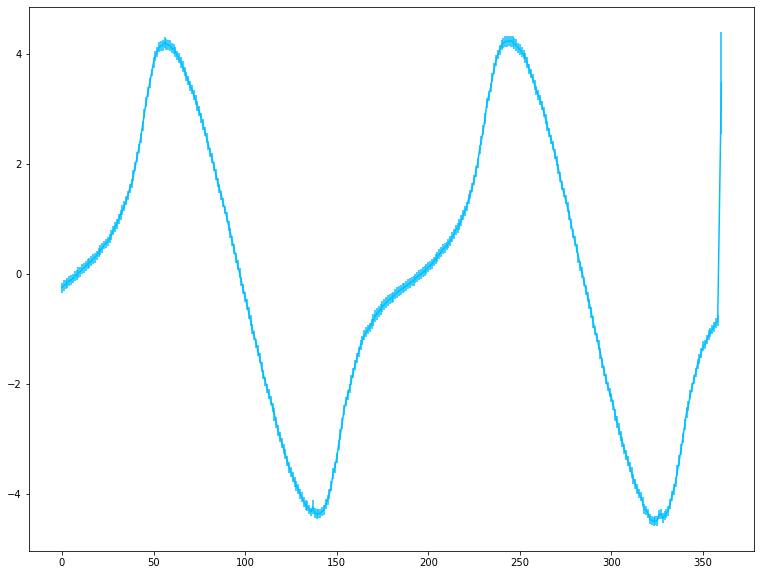

In [72]:
plot_VA();

100%|██████████| 360/360 [00:01<00:00, 259.05it/s]


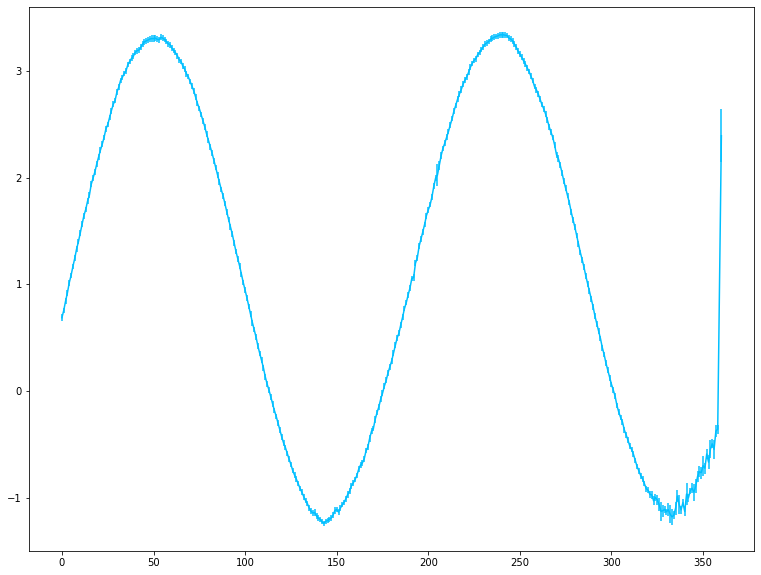

In [73]:
plot_VA(directory='AC_VERDET_ROD_LPF');

(<Figure size 936x360 with 1 Axes>, <AxesSubplot:>)

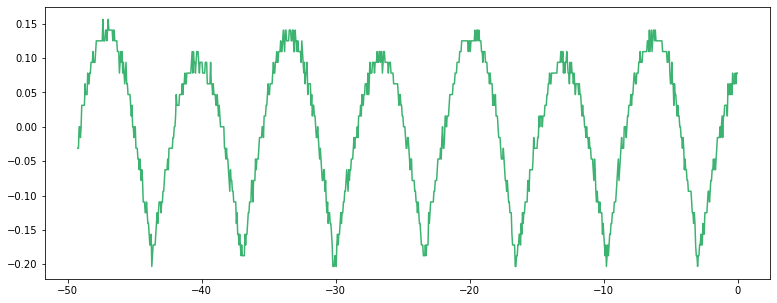

In [50]:
plot_lock_in(200)

In [5]:
x = np.linspace(0,3,1000)
average = 0.99
np.mean([i for i in x if abs(i)/max(x) >= average])

2.986486486486487